In [1]:
import h5py
import numpy as np
import torch
import logging
import time
import matplotlib.pyplot as plt

ftype = torch.float32
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
s_box = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]
s_box_tensor = torch.tensor(s_box, dtype=torch.int32)
hamming_weight = torch.tensor([np.bitwise_count(i) for i in range(256)], dtype=ftype)

Dataset from:
https://github.com/ANSSI-FR/ASCAD/tree/master/STM32_AES_v2

Contains traces of AES encryptions protected with shuffling and boolean masking. The order within operations SubBytes, ShiftRows and MixColumns is shuffled

In [3]:
file_path = "ASCAD_databases/ATMega8515_raw_traces.h5"
f = h5py.File(file_path)
f.keys()

<KeysViewHDF5 ['metadata', 'traces']>

In [4]:
f["metadata"].dtype, f["traces"].shape

(dtype([('plaintext', 'u1', (16,)), ('ciphertext', 'u1', (16,)), ('key', 'u1', (16,)), ('masks', 'u1', (16,))]),
 (60000, 100000))

From metadata we'll use plaintext for CPA, and key to verify our results. We won't be using the masks, that are used to obfuscate sbox output.

In [5]:
key = f["metadata"]["key"]
np.all(key[0] == key)

np.True_

Since all traces used the same key, and we have both plaintext and traces we can perform an SCA attack.

In [6]:
def correlate_traces(plaintext: torch.tensor,
                     traces_centered: torch.tensor,
                     traces_squared_diff_sum: torch.tensor):
    """
    Computes Pearson's R correlation between hamming weights of sbox output for
    each key hypothesis, and traces for each of 256 key hypotheses.

    Correlation is computed as Pearson's r, based on formula:
    correlation = Cov(iv, trace)
                  / ( std(iv) * std(trace))

    Using vectorized computation, this is performed as
    correlation = dot_product((iv - mean(iv), (trace - mean(trace))
                  / sqrt( (iv - mean(iv))^2 * (trace - mean(trace)^2)

    Performance increase is gained by using precomputed traces_centered as well
    as traces_std. 

    Assumes
    - i = amount of traces
    - j = amount of samples per trace
    :plaintexts: tensor of the specific byte of plaintext, shaped (i, 1)
    :traces_centered: precomputed traces - traces.mean(axis=0), shaped (i, j)
    :traces_std: precomputed traces.std(axis=0) shaped (j,)

    :returns: array of correlations shaped (256, j)
    """
    I = plaintext.shape[0]
    iv = torch.zeros((256, I), dtype=ftype)
    for key_hypothesis in range(256):
        # Sbox(key_hypothesis ^ plaintext)
        xor = key_hypothesis ^ plaintext
        switch = torch.index_select(s_box_tensor, 0, xor)
        
        # hamming weight of sbox output
        weights = torch.index_select(hamming_weight, 0, switch)
        iv[key_hypothesis] = weights
    iv_centered = iv - iv.mean(dim=1, keepdim=True)
    iv_centered_squared_sum = torch.sum(iv_centered**2, dim=1, keepdim=True)

    # (iv - iv.mean()) * (traces - traces.mean(dim=0))
    # matrix multiplication between iv_{256, I} and traces_{I, J}
    nom = torch.matmul(iv_centered, traces_centered) 
    # sqrt(sum(iv - iv.mean())**2 * sum(traces - traces.mean(dim=0))**2)
    # inner multiplication is between iv_{256, 1} and traces_{1, J}
    denom = torch.sqrt(iv_centered_squared_sum * traces_squared_diff_sum)
    return nom / denom


The size of traces is quite large at 5.59GB. This will increase four-fold after computing trace.mean() due to conversion to float32. As such correlations will be computed over trace slices during multiple epochs

In [7]:
epochs = 8
with h5py.File(file_path) as f:
    plaintext = f["metadata"]["plaintext"]
    plaintext = torch.tensor(plaintext, dtype=torch.int32)

    traces_shape = f["traces"].shape
    step = traces_shape[1] // epochs

In [8]:
corrs = torch.zeros((16, 256, traces_shape[1]), dtype=ftype)
# perform CPA for each key byte over trace splices 

with h5py.File(file_path) as f:
    for i in range(epochs):
        start_time = time.time()
        # prepare another batch of traces
        traces = f["traces"][:, step * i: step * (i + 1)]
        traces = torch.tensor(traces, dtype=ftype)
        traces_diff = traces - traces.mean(dim=0)
        traces_squared_diff_sum = torch.sum(traces_diff**2, dim=0, keepdim=True)
        del traces
        logger.info(f"epoch {i} loaded in {time.time() - start_time:.2f}")

        start_time = time.time()
        # compute correlations
        for key_byte in range(16):
            epoch_correlations = correlate_traces(plaintext[:, key_byte], traces_diff, traces_squared_diff_sum)
            corrs[key_byte, :, step*i: step*(i+1)] = epoch_correlations
        logger.info(f"epoch {i} computed in {time.time() - start_time:.2f}")

del traces_diff

INFO:__main__:epoch 0 loaded in 14.54
INFO:__main__:epoch 0 computed in 6.40
INFO:__main__:epoch 1 loaded in 12.45
INFO:__main__:epoch 1 computed in 5.63
INFO:__main__:epoch 2 loaded in 13.66
INFO:__main__:epoch 2 computed in 5.52
INFO:__main__:epoch 3 loaded in 14.02
INFO:__main__:epoch 3 computed in 5.74
INFO:__main__:epoch 4 loaded in 17.89
INFO:__main__:epoch 4 computed in 6.79
INFO:__main__:epoch 5 loaded in 13.04
INFO:__main__:epoch 5 computed in 5.64
INFO:__main__:epoch 6 loaded in 11.68
INFO:__main__:epoch 6 computed in 5.66
INFO:__main__:epoch 7 loaded in 11.54
INFO:__main__:epoch 7 computed in 5.71


We work with absolute values, as the direction of correlation does not matter

In [ ]:
abscorr = corrs.abs()
# maximum correlation of each key hypotesis, with sample index
hypo_max_correlation, hypo_sample_index = abscorr.max(dim=2)
# maximum correlation of byte, along corresponding key hypothesis
byte_max_correlation, byte_guess = hypo_max_correlation.max(dim=1)

In [10]:
def check_byte(byte_index, correct_key):
    hypo = byte_guess[byte_index]
    print(f"{byte_index:2}-th byte hypothesis {hypo:3} reached at {hypo_sample_index[byte_index, hypo]}")
    print(f"      has correlation {byte_max_correlation[byte_index]:.2f}", end='')
    if correct_key == byte_guess[byte_index]:
        print(" is correct")
    else:
        print(f"; key is {correct_key:3} with {hypo_max_correlation[byte_index][correct_key]:.5f}")
            

In [11]:
for byte in range(16):
    check_byte(byte, key[0, byte])

 0-th byte hypothesis  77 reached at 32691
      has correlation 0.92 is correct
 1-th byte hypothesis 251 reached at 26448
      has correlation 0.91 is correct
 2-th byte hypothesis 224 reached at 92173
      has correlation 0.04 is correct
 3-th byte hypothesis 242 reached at 98106
      has correlation 0.04 is correct
 4-th byte hypothesis 114 reached at 91183
      has correlation 0.04 is correct
 5-th byte hypothesis  33 reached at 41860
      has correlation 0.11 is correct
 6-th byte hypothesis 254 reached at 96128
      has correlation 0.04 is correct
 7-th byte hypothesis  16 reached at 97118
      has correlation 0.03 is correct
 8-th byte hypothesis   4 reached at 16898
      has correlation 0.02; key is 167 with 0.01678
 9-th byte hypothesis 141 reached at 95140
      has correlation 0.04 is correct
10-th byte hypothesis 240 reached at 46104
      has correlation 0.02; key is  74 with 0.01690
11-th byte hypothesis 220 reached at 93162
      has correlation 0.03 is correct


Our attack succesfully recovered 11 out of 16 key bytes with high correlations on many gueses.

In [12]:
def graph_correlation(byte_index):
    correct_key_byte = key[0, byte_index]
    array = corrs[byte_index]
    for i in range(256):
        if i == correct_key_byte:
            color = "green"
        else:
            color = "gray"
        plt.plot(array[i], color=color)
    plt.title(f"key byte {byte_index}")
    plt.show()

why did we recover bytes 0 and 1 so well, are they not protected?
there's boolean masking, is it applied to these bytes as well?

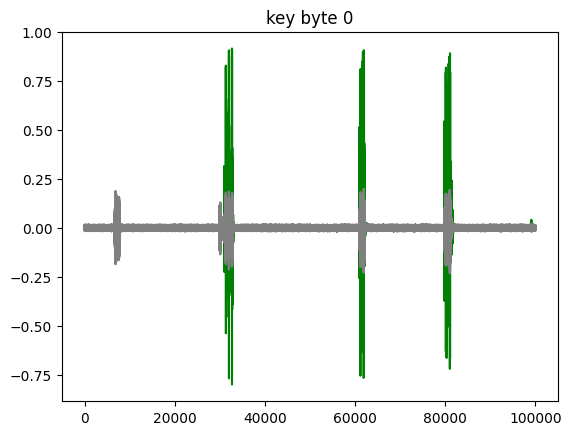

 0-th byte hypothesis  77 reached at 32691
      has correlation 0.92 is correct


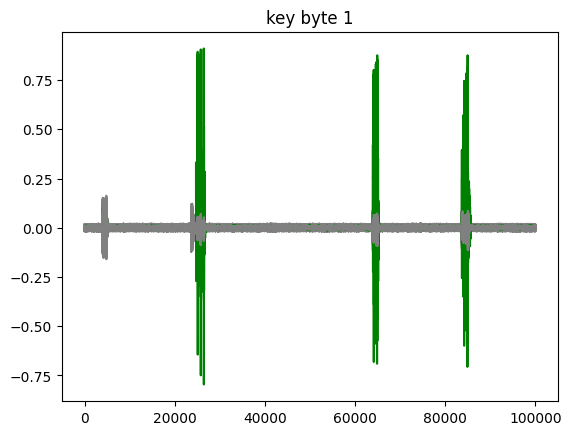

 1-th byte hypothesis 251 reached at 26448
      has correlation 0.91 is correct


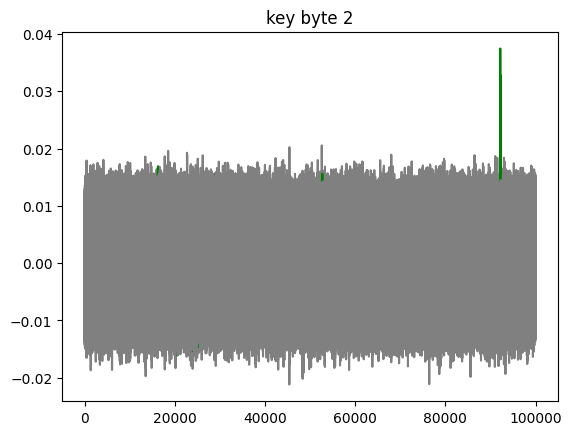

 2-th byte hypothesis 224 reached at 92173
      has correlation 0.04 is correct


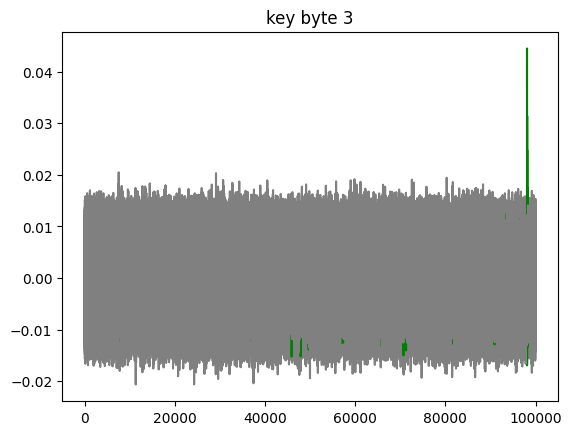

 3-th byte hypothesis 242 reached at 98106
      has correlation 0.04 is correct


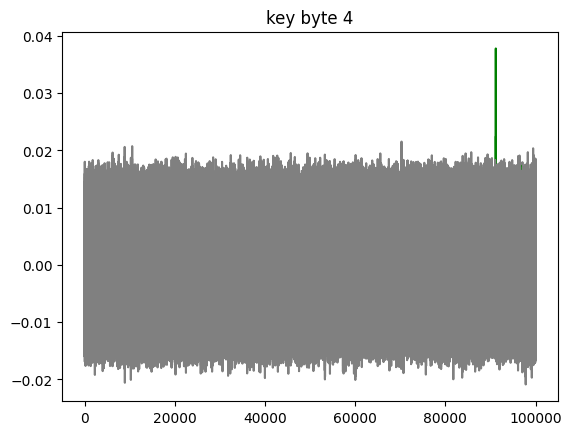

 4-th byte hypothesis 114 reached at 91183
      has correlation 0.04 is correct


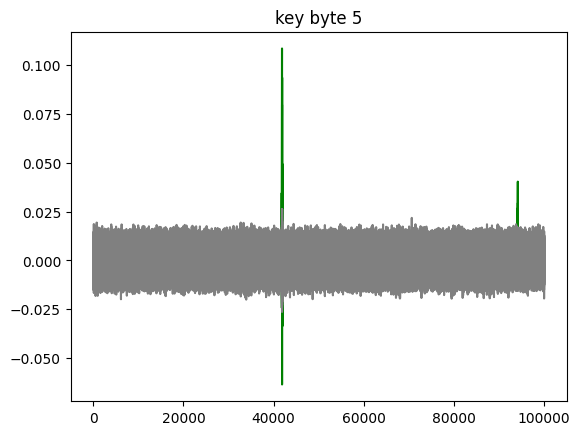

 5-th byte hypothesis  33 reached at 41860
      has correlation 0.11 is correct


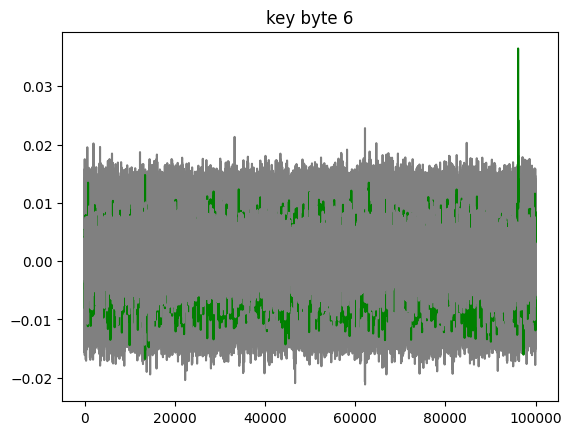

 6-th byte hypothesis 254 reached at 96128
      has correlation 0.04 is correct


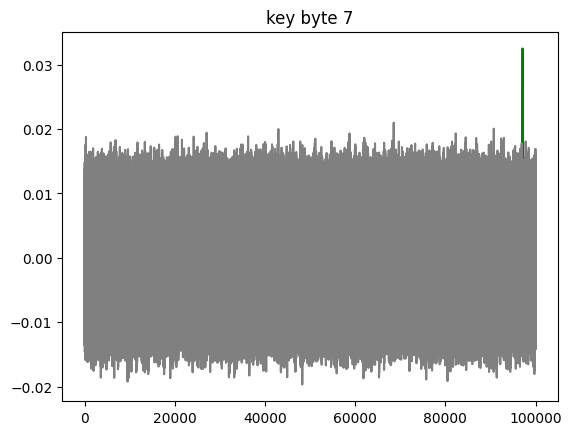

 7-th byte hypothesis  16 reached at 97118
      has correlation 0.03 is correct


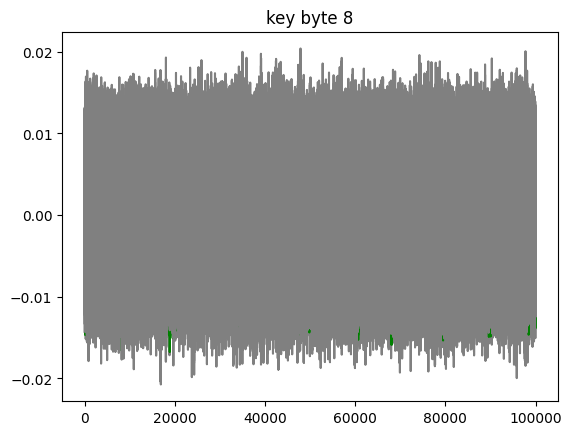

 8-th byte hypothesis   4 reached at 16898
      has correlation 0.02; key is 167 with 0.01678


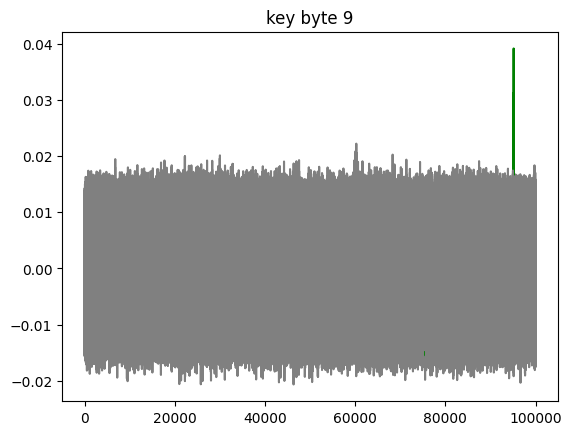

 9-th byte hypothesis 141 reached at 95140
      has correlation 0.04 is correct


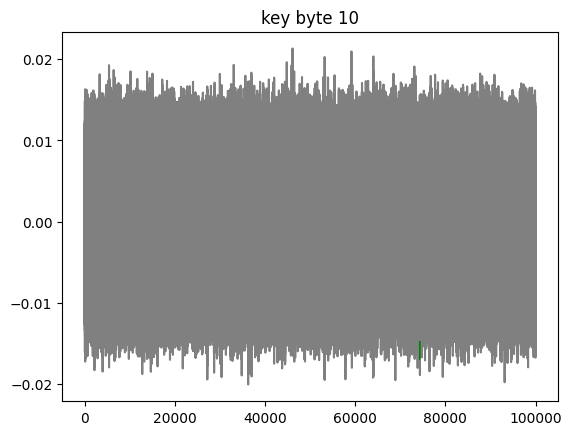

10-th byte hypothesis 240 reached at 46104
      has correlation 0.02; key is  74 with 0.01690


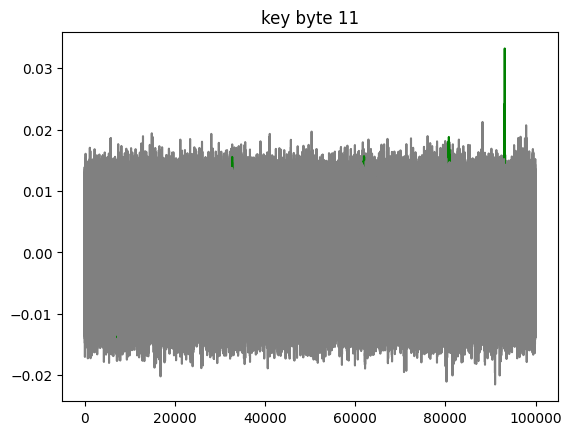

11-th byte hypothesis 220 reached at 93162
      has correlation 0.03 is correct


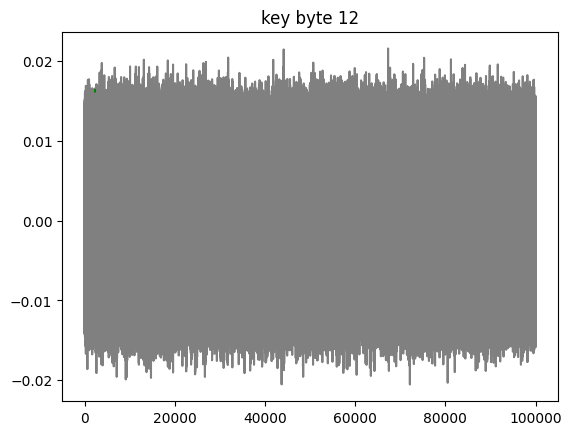

12-th byte hypothesis 225 reached at 67291
      has correlation 0.02; key is 142 with 0.01638


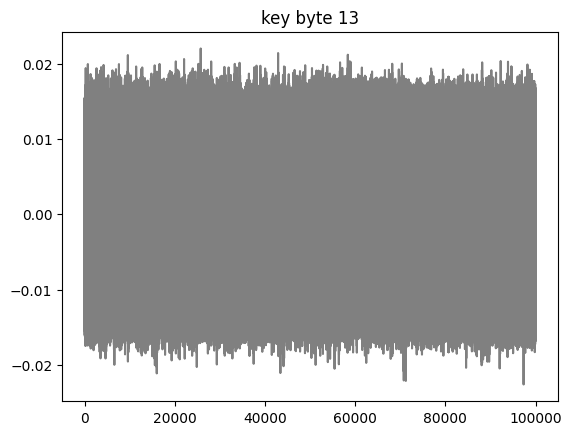

13-th byte hypothesis  57 reached at 97347
      has correlation 0.02; key is  73 with 0.01395


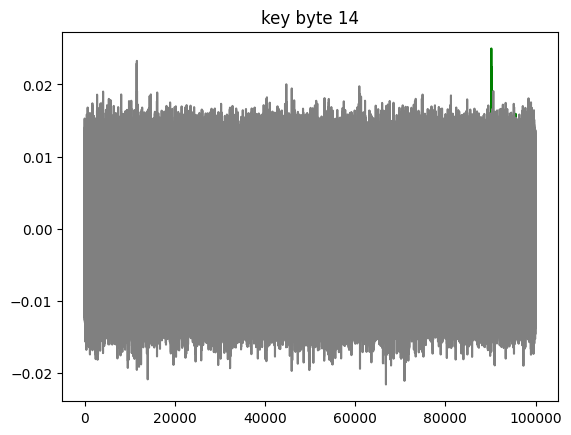

14-th byte hypothesis   4 reached at 90194
      has correlation 0.02 is correct


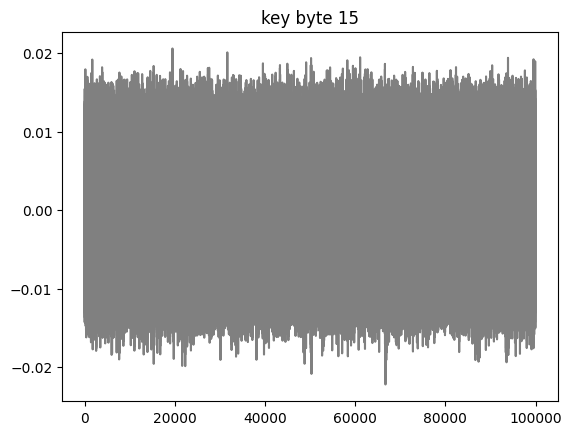

15-th byte hypothesis 255 reached at 66717
      has correlation 0.02; key is 105 with 0.01487


In [13]:
for byte in range(16):
    graph_correlation(byte)
    check_byte(byte, key[0, byte])

Correlation for correct key byte 0 hypothesis spiked 3 times.

Hypotheses for 8-th key byte were low, peaking around 0.02

we can also compare correlations of all hypotheses on sample with highest correlation

In [15]:
def show_best_sample(byte_index):
    best_hypo = byte_guess[byte_index]
    print(hypo_sample_index.shape)
    sample = hypo_sample_index[byte_index, best_hypo]
    plt.plot(corrs[byte_index, :, sample])

torch.Size([16, 256])


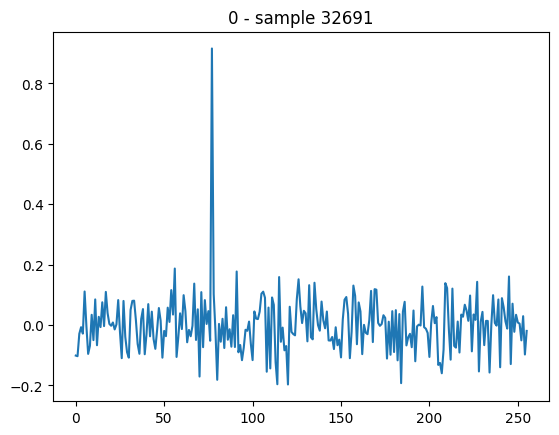

torch.Size([16, 256])


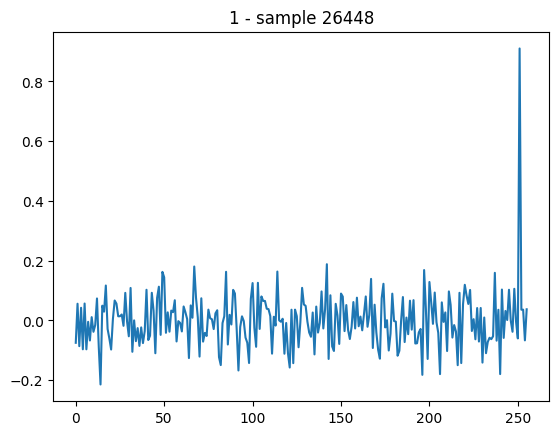

torch.Size([16, 256])


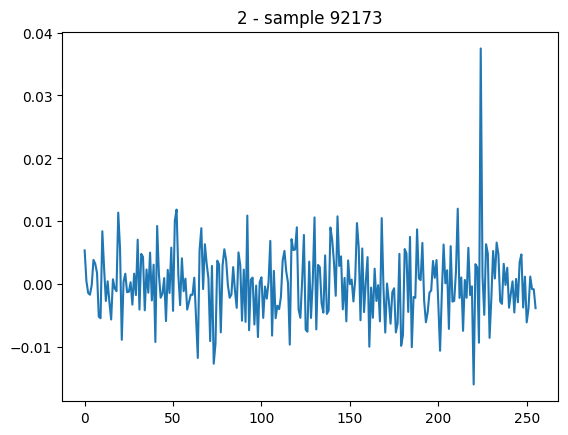

torch.Size([16, 256])


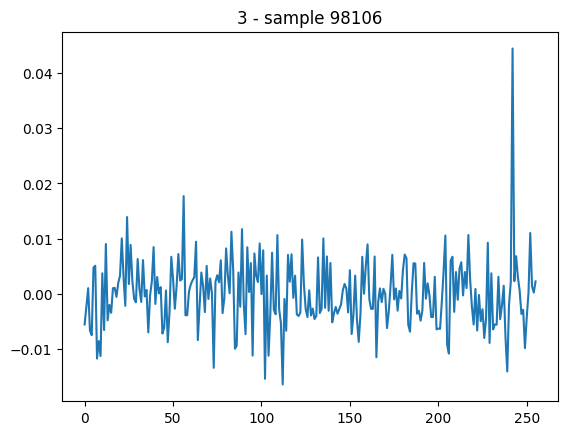

torch.Size([16, 256])


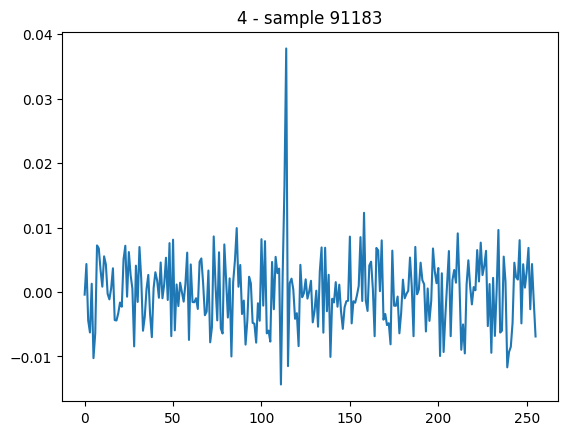

torch.Size([16, 256])


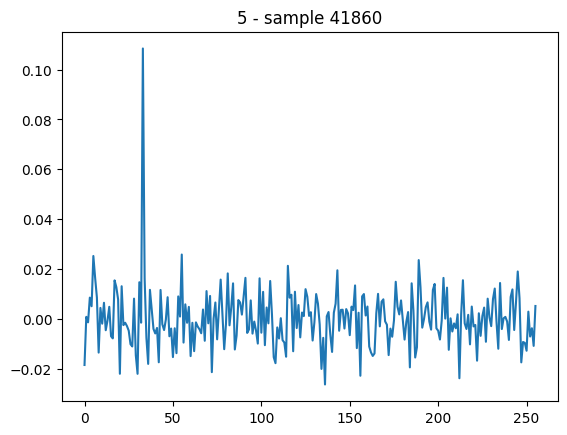

torch.Size([16, 256])


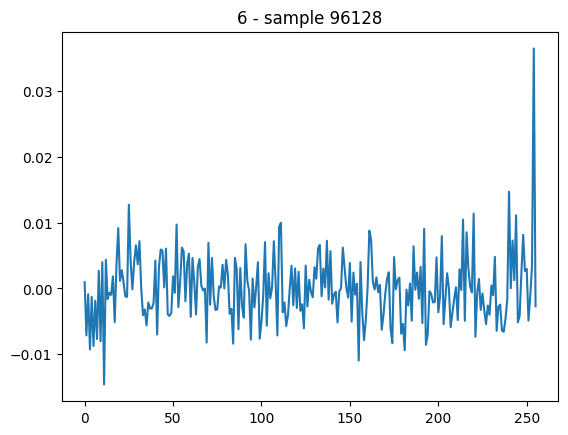

torch.Size([16, 256])


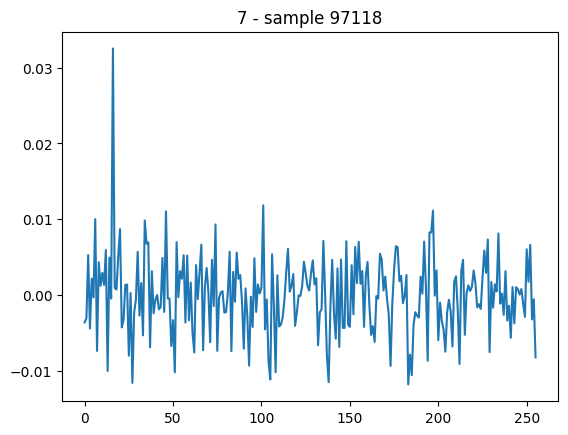

torch.Size([16, 256])


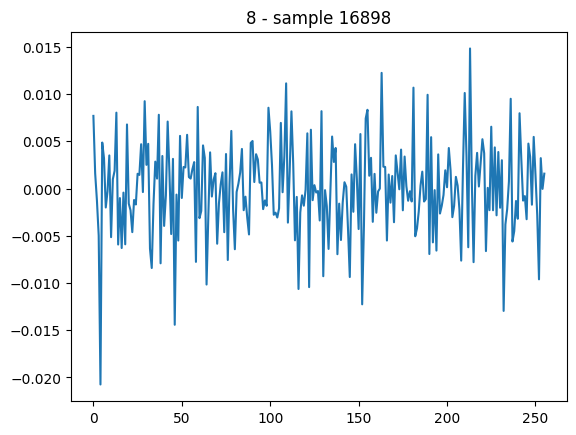

torch.Size([16, 256])


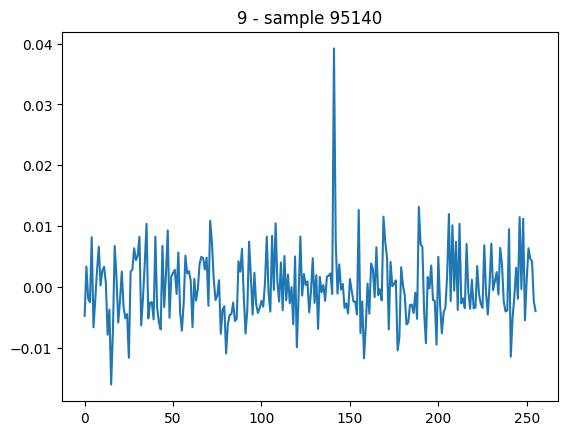

torch.Size([16, 256])


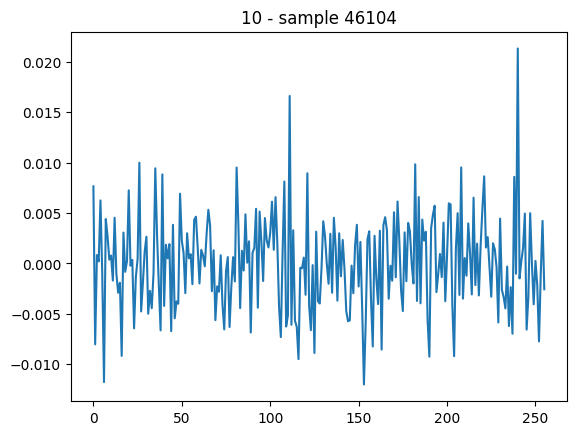

torch.Size([16, 256])


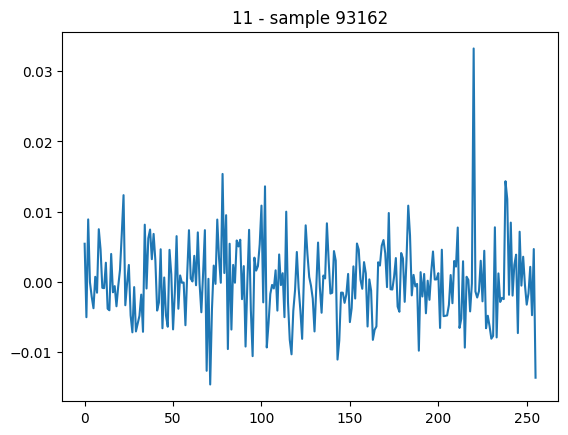

torch.Size([16, 256])


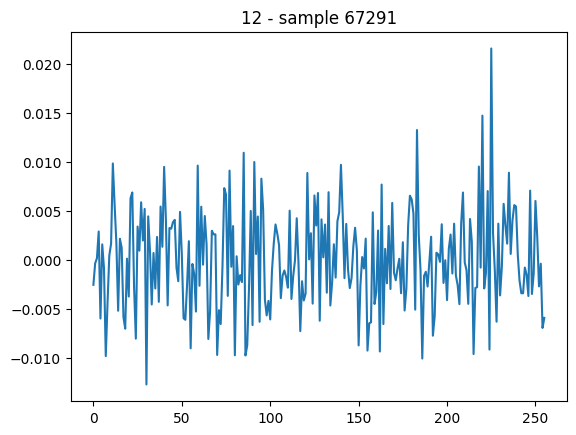

torch.Size([16, 256])


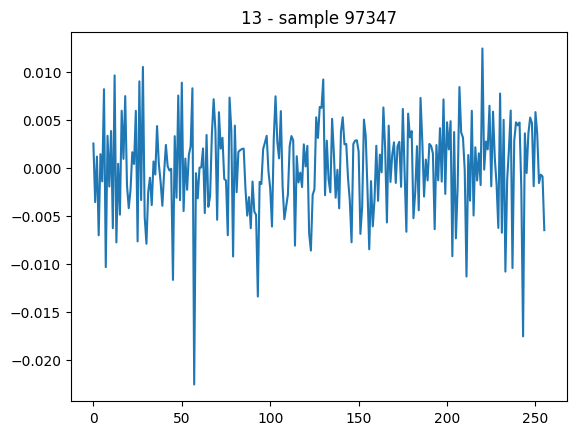

torch.Size([16, 256])


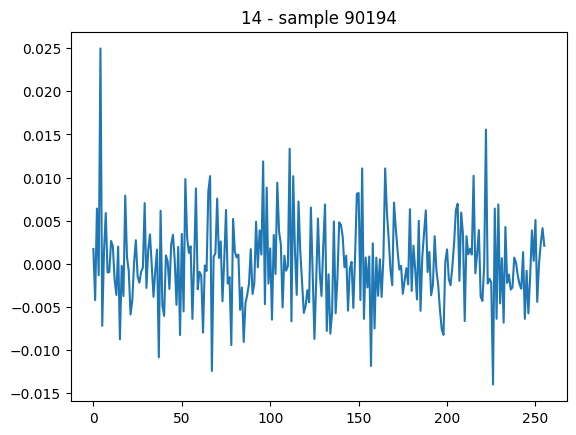

torch.Size([16, 256])


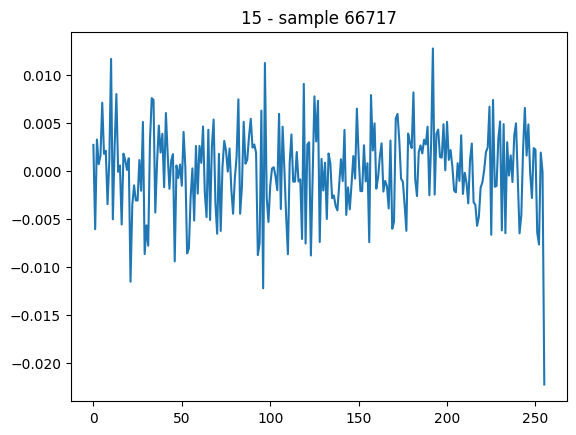

In [17]:
for byte in range(16):
    show_best_sample(byte)
    plt.title(f"{byte} - sample {hypo_sample_index[byte, byte_guess[byte]]}")
    plt.show()